# Building Rollup hierarchies in python with Treelib and atoti
\[_In case you’re unable to see the atoti visualizations in GitHub, try viewing the notebook in [nbviewer](https://nbviewer.org/github/atoti/notebooks/blob/main/notebooks/02-technical-tutorials/rollup-hierarchies/main.ipynb)._]

This notebook is illustrating how to create a product catalog inside a BI application using Treelib and atoti. Full story is available on this link:

https://medium.com/atoti/building-rollup-hierarchies-in-python-with-treelib-and-atoti-ffc61fbac69c?source=friends_link&sk=0b8b36c30a588af4ac0fc7a6f38d2a6f

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=rollup-hierarchies" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="atoti table" /></a></div>

# Credits for the sample data

The sample data for this project was sourced from this edu course [Data analytics with R](https://stepik.org/course/724/promo). The data has been transformed. I'm hosting my version of the data on s3:

In [1]:
# !conda install -c conda-forge python-wget -y
# !pip install treelib atoti[aws]

In [2]:
import zipfile

import pandas as pd
import wget
from IPython.display import clear_output, display
from treelib import Node, Tree

In [3]:
def bar_custom(current, total, width=80):
    clear_output(wait=True)
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))


url = "http://data.atoti.io/notebooks/rollup-hierarchy/rollup-hierarchies.zip"
filename = wget.download(url, bar=bar_custom)

In [4]:
# unzipping the file
with zipfile.ZipFile("rollup-hierarchies.zip", "r") as zip_ref:
    zip_ref.extractall()

# Reading parent-child product catalog description

In [5]:
categories_df = pd.read_csv("categories.csv")
categories_df.head()

,category_id,parent_id,name,link_url
0,925,1212,Shoe dryers,http://e96.ru/household_appliances/washing/sus...
1,776,683,Football,http://e96.ru/sporting_goods/football
2,735,1175,Chests of drawers for baths,http://e96.ru/furniture/bathroom/komody_dlja_vann
3,1513,1504,Houses for dogs,http://e96.ru/zootovary/tovary_dlja_sobak/domi...
4,1357,1086,Sledgehammers,http://e96.ru/tools/hand_tools/kuvaldy


In [6]:
# creating a dict to lookup a name for an id
cat_dict = dict(zip(categories_df.category_id, categories_df.name))

# Populating a tree in Treelib

In [7]:
tree = Tree()
tree.create_node("Product Catalogue", 0)

# Creating nodes under root
for i, c in categories_df.iterrows():
    tree.create_node(c["name"], c["category_id"], parent=0)

# Moving nodes to reflect the parent-child relationship
for i, c in categories_df.iterrows():
    if c["parent_id"] == c["parent_id"]:
        tree.move_node(c["category_id"], c["parent_id"])

# paths_to_leaves

Having created a Tree using Treelib, it's trivial to obtain all paths to leaves:

In [8]:
tree.paths_to_leaves()[:5]

[[0, 16, 1212, 925],
 [0, 1342, 1175, 735],
 [0, 1502, 1504, 1513],
 [0, 129, 1086, 1357],
 [0, 304, 1037, 530]]

The following will show that the tree is unbalanced:

In [9]:
print(
    "Min depth is {}, max depth is {}".format(
        min([len(i) for i in tree.paths_to_leaves()]),
        max([len(i) for i in tree.paths_to_leaves()]),
    )
)

Min depth is 3, max depth is 4


Although parent-child pairs are a very natural way to express hierarchies, we can’t use them in its raw form for slicing and dicing. Think about a table in Excel — with different levels of a tree in separate columns, we can combine them in a pivot table to roll up and down through the levels of the catalogue. 

Let’s extract the levels of the tree into separate columns, and save into the `categories_hierarchy.csv` file:

In [10]:
with open("categories_hierarchy.csv", "w+") as outfile:
    outfile.write(
        ";".join(["Category_Lvl" + str(i + 1) for i in range(tree.depth())]) + "\n"
    )
    for p in tree.paths_to_leaves():
        outfile.write(
            ";".join(
                [cat_dict[pi] for pi in p[1:]]
                + [cat_dict[p[-1]]]
                * (
                    tree.depth() - len(p) + 1
                )  # I'm adding the last item for the shorter branches to balance the tree
            )
            + "\n"
        )

In [11]:
pd.read_csv("categories_hierarchy.csv", sep=";").head(3)

,Category_Lvl1,Category_Lvl2,Category_Lvl3
0,Household products,Washing and drying,Shoe dryers
1,Furniture,Bathroom furniture,Chests of drawers for baths
2,Pet products,Products for dogs,Houses for dogs


# Launchin BI app using atoti

In [12]:
import atoti as tt

session = tt.Session(java_options=["-Xms2G", "-Xmx10G"])

events_tbl = session.read_csv(
    "events.csv",
    table_name="Events",
    keys=["externalsessionid", "eventtype"],
)

In [13]:
events_tbl.head()

,,timestamp,eventdate,ordernumber,pricecents,totalcents,quantity,product_id,duration
externalsessionid,eventtype,,,,,,,,
98472,purchase,1460438910936,2016-04-12,21910.0,776.0,3104.0,4.0,12236.0,N/A
55431,purchase,1453372839388,2016-01-21,23663.0,1218.0,1218.0,1.0,24027.0,N/A
73132,purchase,1455783989550,2016-02-18,77052.0,317.0,3170.0,10.0,24268.0,N/A
41297,purchase,1459005667873,2016-03-26,54769.0,116.0,116.0,1.0,31696.0,N/A
44134,purchase,1457623580487,2016-03-10,54727.0,556.0,556.0,1.0,50164.0,N/A


In [14]:
{"columns": len(events_tbl.columns), "rows": len(events_tbl)}

{'columns': 10, 'rows': 27112}

In [15]:
cube = session.create_cube(events_tbl, "Sales Analytics")

In [16]:
session.link()

Open the notebook in JupyterLab with the Atoti extension enabled to see this link.

In [17]:
products_tbl = session.read_csv(
    "products.csv", table_name="Product Attributes", separator=";", process_quotes=True
)
products_tbl.head()

,product_id,name,price,available,brand
0,445535,LoG LWtCns,140,False,Vitesse
1,516079,xmne cHSoe,437,True,Amtel
2,65313,aSBiPAX aAmnlU,1090,True,HTC
3,755102,DgAu pwCVl,288,False,Endisa
4,727179,nreoich,2304,True,Alcatel


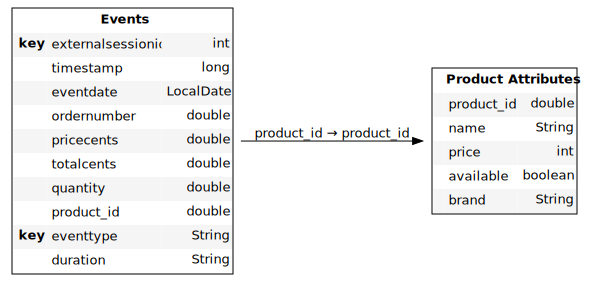

In [18]:
events_tbl.join(products_tbl, events_tbl["product_id"] == products_tbl["product_id"])
cube.schema

In [19]:
# loading product to category mapping into the cube
products_categories_tbl = session.read_csv(
    "product-categories.csv", table_name="Categories"
)
events_tbl.join(
    products_categories_tbl,
    events_tbl["product_id"] == products_categories_tbl["product_id"],
)

In [20]:
# loading categories hierarchy into the cube
categories_tree_tbl = session.read_csv(
    "categories_hierarchy.csv",
    table_name="Categories Hierarchy",
    separator=";",
    keys=["Category_Lvl3"],
)
products_categories_tbl.join(
    categories_tree_tbl,
    products_categories_tbl["Category"] == categories_tree_tbl["Category_Lvl3"],
)

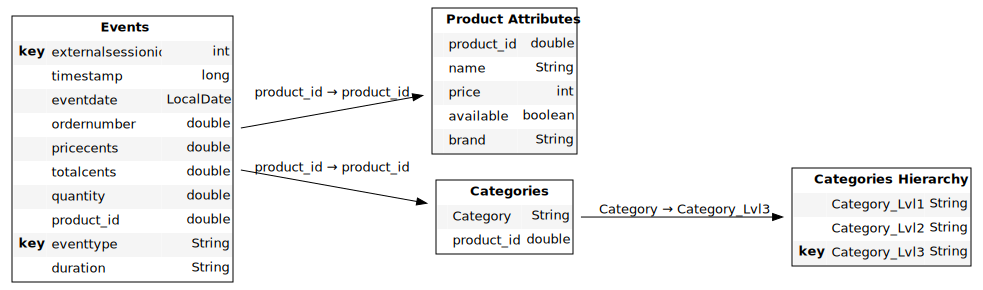

In [21]:
cube.schema

In [22]:
# Creating a multi-level hierarchy to automatically expand data:
cube.hierarchies["Catalog"] = [
    cube.levels["Category_Lvl1"],
    cube.levels["Category_Lvl2"],
    cube.levels["Category"],
]

In [23]:
# A measure to count unique sessions
cube.measures["UniqueSessionsCount"] = tt.agg.count_distinct(
    events_tbl["externalsessionid"]
)

Take note that the `UniqueSessionsCount` for `eventtype` level is higher than at the `Category_Lvl1` level. This is because the same `externalsessionid` may exists for both purchase and view events.

In [24]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to see this widget.

In [25]:
cube.measures["Sales"] = cube.measures["totalcents.SUM"]
cube.measures["Sales as % of Grand Total"] = cube.measures["Sales"] / tt.total(
    cube.measures["Sales"], cube.hierarchies["Catalog"]
)
cube.measures["Sales as % of Grand Total"].formatter = "DOUBLE[0.00%]"

In [26]:
session.visualize()

Open the notebook in JupyterLab with the Atoti extension enabled to build this widget.

# Start building dashboards

In [27]:
session.link()

Open the notebook in JupyterLab with the Atoti extension enabled to see this link.

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=rollup-hierarchies" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="atoti table" /></a></div>